In [1]:
from pathlib import Path
import sys

REPO_ROOT = Path.cwd().resolve()
if (REPO_ROOT / "src").exists() is False:
    # If you opened the notebook from inside /notebooks
    REPO_ROOT = REPO_ROOT.parent

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

In [2]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H%M")
FIG_DIR = REPO_ROOT / "outputs" / "figures"
TAB_DIR = REPO_ROOT / "outputs" / "tables"

FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
import sys
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

HERE = Path.cwd().resolve()
candidates = [HERE, HERE.parent, HERE.parent.parent]

REPO_ROOT = None
for c in candidates:
    if (c / "src").exists():
        REPO_ROOT = c
        break

if REPO_ROOT is None:
    raise RuntimeError(f"Could not find repo root from {HERE}. Expected a folder containing /src.")

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from src.config import base_case
from src.model import run_deterministic_unit_econ, result_to_dict

In [4]:
def truncated_normal(n: int, mean: float, sd: float, low: float, high: float, rng: np.random.Generator) -> np.ndarray:
    out = np.empty(n, dtype=float)
    filled = 0
    while filled < n:
        draw = rng.normal(mean, sd, size=(n - filled) * 3)
        draw = draw[(draw >= low) & (draw <= high)]
        take = min(len(draw), n - filled)
        out[filled:filled + take] = draw[:take]
        filled += take
    return out


def simulate_profit(
    base,
    n: int,
    dr_mean: float,
    dr_sd: float,
    cac_mean: float,
    cac_sd: float,
    fc_mean: float,
    fc_sd: float,
    rng: np.random.Generator,
) -> pd.DataFrame:
    """Run Monte Carlo for profit under a given set of distribution parameters."""
    default_field = "default_rate" if hasattr(base, "default_rate") else "annual_default_rate"

    dr = truncated_normal(n, dr_mean, dr_sd, low=0.01, high=0.30, rng=rng)
    cac = truncated_normal(n, cac_mean, cac_sd, low=50.0, high=800.0, rng=rng)
    fc = truncated_normal(n, fc_mean, fc_sd, low=0.00, high=0.25, rng=rng)

    profits = np.empty(n, dtype=float)
    for i in range(n):
        a = base.model_copy(update={
            default_field: float(dr[i]),
            "cac_per_account": float(cac[i]),
            "funding_cost_rate": float(fc[i]),
        })
        d = result_to_dict(run_deterministic_unit_econ(a))
        profits[i] = d["contribution_profit"]

    return pd.DataFrame({
        "profit": profits,
        "default_rate": dr,
        "cac_per_account": cac,
        "funding_cost_rate": fc,
    })


def risk_metrics(profit: np.ndarray) -> dict:
    """Compute basic risk metrics used in the writeup."""
    profit = np.asarray(profit, dtype=float)
    expected_profit = float(profit.mean())
    prob_loss = float((profit < 0).mean())
    var_5 = float(np.quantile(profit, 0.05))
    es_5 = float(profit[profit <= var_5].mean())
    return {
        "expected_profit": expected_profit,
        "prob_loss": prob_loss,
        "var_5": var_5,
        "es_5": es_5,
    }

In [5]:
def truncated_normal(n: int, mean: float, sd: float, low: float, high: float, rng: np.random.Generator) -> np.ndarray:
    out = np.empty(n, dtype=float)
    filled = 0
    while filled < n:
        draw = rng.normal(mean, sd, size=(n - filled) * 3)
        draw = draw[(draw >= low) & (draw <= high)]
        take = min(len(draw), n - filled)
        out[filled:filled + take] = draw[:take]
        filled += take
    return out


def simulate_profit(
    base,
    n: int,
    dr_mean: float,
    dr_sd: float,
    cac_mean: float,
    cac_sd: float,
    fc_mean: float,
    fc_sd: float,
    rng: np.random.Generator,
) -> pd.DataFrame:
    """Run Monte Carlo for profit under a given set of distribution parameters."""
    default_field = "default_rate" if hasattr(base, "default_rate") else "annual_default_rate"

    dr = truncated_normal(n, dr_mean, dr_sd, low=0.01, high=0.30, rng=rng)
    cac = truncated_normal(n, cac_mean, cac_sd, low=50.0, high=800.0, rng=rng)
    fc = truncated_normal(n, fc_mean, fc_sd, low=0.00, high=0.25, rng=rng)

    profits = np.empty(n, dtype=float)
    for i in range(n):
        a = base.model_copy(update={
            default_field: float(dr[i]),
            "cac_per_account": float(cac[i]),
            "funding_cost_rate": float(fc[i]),
        })
        d = result_to_dict(run_deterministic_unit_econ(a))
        profits[i] = d["contribution_profit"]

    return pd.DataFrame({
        "profit": profits,
        "default_rate": dr,
        "cac_per_account": cac,
        "funding_cost_rate": fc,
    })


def risk_metrics(profit: np.ndarray) -> dict:
    """Compute basic risk metrics used in the writeup."""
    profit = np.asarray(profit, dtype=float)
    expected_profit = float(profit.mean())
    prob_loss = float((profit < 0).mean())
    var_5 = float(np.quantile(profit, 0.05))
    es_5 = float(profit[profit <= var_5].mean())
    return {
        "expected_profit": expected_profit,
        "prob_loss": prob_loss,
        "var_5": var_5,
        "es_5": es_5,
    }

In [6]:
base = base_case()

# Baseline distribution parameters (use what you used in Notebook 03)
baseline = {
    "dr_mean": float(getattr(base, "default_rate", getattr(base, "annual_default_rate"))),
    "dr_sd": 0.015,
    "cac_mean": float(base.cac_per_account),
    "cac_sd": 40.0,
    "fc_mean": float(base.funding_cost_rate),
    "fc_sd": 0.01,
}

scenarios = {
    "Baseline": baseline,

    # Coherent macro shock: defaults + CAC + funding worsen together
    "Recession": {
        "dr_mean": baseline["dr_mean"] + 0.04,   # +4pp defaults
        "dr_sd": 0.020,
        "cac_mean": baseline["cac_mean"] * 1.25, # +25% CAC
        "cac_sd": 55.0,
        "fc_mean": baseline["fc_mean"] + 0.02,   # +2pp funding cost
        "fc_sd": 0.015,
    },

    "Rate Spike": {
        "dr_mean": baseline["dr_mean"] + 0.01,   # mild credit effect
        "dr_sd": 0.015,
        "cac_mean": baseline["cac_mean"] * 1.05, # slightly harder acquisition
        "cac_sd": 45.0,
        "fc_mean": baseline["fc_mean"] + 0.03,   # +3pp funding cost
        "fc_sd": 0.015,
    },

    "Competitive Pressure": {
        "dr_mean": baseline["dr_mean"],          # credit unchanged
        "dr_sd": 0.015,
        "cac_mean": baseline["cac_mean"] * 1.35, # +35% CAC
        "cac_sd": 60.0,
        "fc_mean": baseline["fc_mean"],          # funding unchanged
        "fc_sd": 0.01,
    },

    "Credit Deterioration": {
        "dr_mean": baseline["dr_mean"] + 0.05,   # +5pp defaults
        "dr_sd": 0.020,
        "cac_mean": baseline["cac_mean"],
        "cac_sd": 40.0,
        "fc_mean": baseline["fc_mean"],
        "fc_sd": 0.01,
    },
}

scenarios

{'Baseline': {'dr_mean': 0.06,
  'dr_sd': 0.015,
  'cac_mean': 250.0,
  'cac_sd': 40.0,
  'fc_mean': 0.06,
  'fc_sd': 0.01},
 'Recession': {'dr_mean': 0.1,
  'dr_sd': 0.02,
  'cac_mean': 312.5,
  'cac_sd': 55.0,
  'fc_mean': 0.08,
  'fc_sd': 0.015},
 'Rate Spike': {'dr_mean': 0.06999999999999999,
  'dr_sd': 0.015,
  'cac_mean': 262.5,
  'cac_sd': 45.0,
  'fc_mean': 0.09,
  'fc_sd': 0.015},
 'Competitive Pressure': {'dr_mean': 0.06,
  'dr_sd': 0.015,
  'cac_mean': 337.5,
  'cac_sd': 60.0,
  'fc_mean': 0.06,
  'fc_sd': 0.01},
 'Credit Deterioration': {'dr_mean': 0.11,
  'dr_sd': 0.02,
  'cac_mean': 250.0,
  'cac_sd': 40.0,
  'fc_mean': 0.06,
  'fc_sd': 0.01}}

In [7]:
N = 20000
rng = np.random.default_rng(123)

rows = []
scenario_sims = {}

for name, p in scenarios.items():
    sim = simulate_profit(
        base=base,
        n=N,
        dr_mean=p["dr_mean"], dr_sd=p["dr_sd"],
        cac_mean=p["cac_mean"], cac_sd=p["cac_sd"],
        fc_mean=p["fc_mean"], fc_sd=p["fc_sd"],
        rng=rng,
    )
    scenario_sims[name] = sim
    m = risk_metrics(sim["profit"].to_numpy())
    rows.append({
        "scenario": name,
        "expected_profit": m["expected_profit"],
        "prob_loss": m["prob_loss"],
        "var_5": m["var_5"],
        "es_5": m["es_5"],
        "dr_mean": p["dr_mean"],
        "cac_mean": p["cac_mean"],
        "funding_cost_mean": p["fc_mean"],
    })

summary = pd.DataFrame(rows).set_index("scenario").sort_values("expected_profit", ascending=False)
summary

,expected_profit,prob_loss,var_5,es_5,dr_mean,cac_mean,funding_cost_mean
scenario,,,,,,,
Baseline,-1.615714e+06,0.86925,-3.980905e+06,-4.578358e+06,0.06,250.0,0.06
Competitive Pressure,-3.351634e+06,0.97670,-6.113718e+06,-6.808440e+06,0.06,337.5,0.06
Rate Spike,-4.209944e+06,0.99535,-6.858013e+06,-7.559859e+06,0.07,262.5,0.09
Credit Deterioration,-5.096684e+06,0.99835,-7.898419e+06,-8.626813e+06,0.11,250.0,0.06
Recession,-6.745607e+06,0.99975,-9.970898e+06,-1.076268e+07,0.10,312.5,0.08


Saved: C:\Users\Finn Case\OneDrive\Desktop\fintech-unit-econ-sim\outputs\tables\scenario_summary_2026-02-25_2149.csv


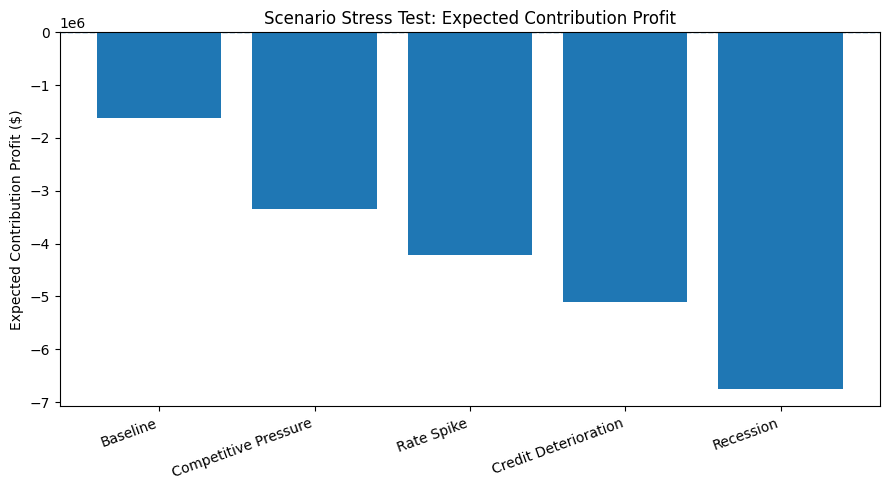

Saved: C:\Users\Finn Case\OneDrive\Desktop\fintech-unit-econ-sim\outputs\figures\scenario_expected_profit_2026-02-25_2149.png


In [8]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H%M")
figs_dir = REPO_ROOT / "outputs" / "figures"
tables_dir = REPO_ROOT / "outputs" / "tables"
figs_dir.mkdir(parents=True, exist_ok=True)
tables_dir.mkdir(parents=True, exist_ok=True)

# Save table
csv_path = tables_dir / f"scenario_summary_{timestamp}.csv"
summary.to_csv(csv_path)
print("Saved:", csv_path)

# Plot expected profit by scenario
plt.figure(figsize=(9,5))
plt.bar(summary.index, summary["expected_profit"])
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Scenario Stress Test: Expected Contribution Profit")
plt.ylabel("Expected Contribution Profit ($)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()

fig_path = figs_dir / f"scenario_expected_profit_{timestamp}.png"
plt.savefig(fig_path, dpi=200)
plt.show()

print("Saved:", fig_path)